# 🎓 Maestría en Inteligencia Artificial Aplicada

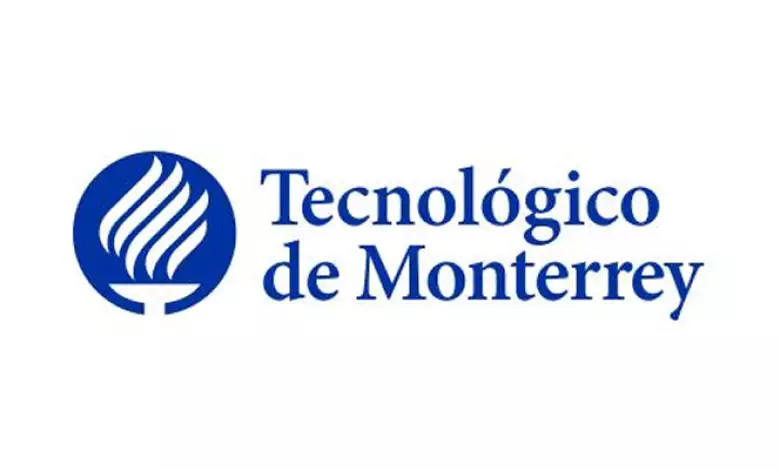

## 🖼️ **Proyecto Integrador**

### 👨‍🏫 **Profesores**

- **Profesor Titular:** Dra. Grettel Barceló Alonso
- **Asesor:** Dr. Horacio Martínez Alfaro

## **<font color="#895cf9">Avance 3. Baseline</font>**
### **Spin Compass**

### 📌 **Detalles de la Actividad**

- **Código:** 10.5 Google Colab
- **Título:** Avance 3. Baseline
- **Fecha de entrega:** 15 de feb de 2026 23:59
- **Formato de entrega:** Notebook (.ipynb) + Informe
- **Modalidad:** Equipo

## 👥 **Equipo 5**

### 🚀 **Nuestro Equipo**

  - Tania Alicia Caballero Saavedra - A01795957
  - Oscar Enrique García García - A01016093
  - Dante Rosas Fragoso – A01795850



a. Configuración del Entorno y Carga de Datos
Instalación de librerías: Se instalan dependencias clave como sentence-transformers (para embeddings) y PyMuPDF (para leer PDFs).

Conexión a Drive: Se monta Google Drive para acceder a la carpeta del proyecto donde residen los documentos crudos (data/raw).

Lectura de Documentos: Se utiliza una función para extraer texto de archivos PDF, TXT o MD encontrados en la ruta especificada.

In [1]:
!pip install sentence-transformers
!pip install PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 40.6 MB/s eta 0:00:00


In [2]:
"""
Script de Chunking Semántico Avanzado
Integra lógica original de limpieza con nuevos algoritmos:
1. Max-Min Semantic Chunking
2. Growing Window Semantic Chunking
"""

import math
import os
import re
from pathlib import Path
from typing import List

import fitz  # PyMuPDF
import numpy as np
import pandas as pd
import tiktoken
from sentence_transformers import SentenceTransformer, util
from google.colab import drive

# --- 1. Configuración y Constantes ---

try:
    drive.mount("/content/drive")
    # Ruta específica del usuario original
    DRIVE_PATH = Path("/content/drive/MyDrive/Colab_Notebooks/MNA/Proyecto_Integrador-main")

    if DRIVE_PATH.exists():
        PROJECT_ROOT = DRIVE_PATH
        print(f"Ruta de Drive encontrada: {PROJECT_ROOT}")
    else:
        # Si la carpeta específica no existe en tu Drive, usamos una local
        print("La ruta específica no se encontró en Drive. Usando entorno local.")
        PROJECT_ROOT = Path("/content/proyecto_integrador")

except Exception as e:
    print(f"No se pudo montar Drive ({e}). Usando entorno local.")
    PROJECT_ROOT = Path("/content/proyecto_integrador")

# Definimos y creamos la ruta de datos raw si no existe
RAW_DATA_PATH = PROJECT_ROOT / "data" / "raw"
RAW_DATA_PATH.mkdir(parents=True, exist_ok=True)

print(f"Los archivos se buscarán en: {RAW_DATA_PATH}")
print("NOTA: Si no tienes los archivos ahí, súbelos manualmente a esa carpeta en el panel de la izquierda.")

# Configuración de Modelos
TOKENIZER_MODEL = "cl100k_base"  # Para conteo de tokens
EMBEDDING_MODEL_NAME = "paraphrase-multilingual-MiniLM-L12-v2"

# Inicialización de Modelos
encoder = tiktoken.get_encoding(TOKENIZER_MODEL)
print(f"Cargando modelo de embeddings: {EMBEDDING_MODEL_NAME}...")
embedding_model = SentenceTransformer(EMBEDDING_MODEL_NAME)




Mounted at /content/drive
Ruta de Drive encontrada: /content/drive/MyDrive/Colab_Notebooks/MNA/Proyecto_Integrador-main
Los archivos se buscarán en: /content/drive/MyDrive/Colab_Notebooks/MNA/Proyecto_Integrador-main/data/raw
NOTA: Si no tienes los archivos ahí, súbelos manualmente a esa carpeta en el panel de la izquierda.
Cargando modelo de embeddings: paraphrase-multilingual-MiniLM-L12-v2...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/526 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

b. Preprocesamiento y Limpieza de Texto
Reducción de Ruido: Se implementa una clase NoiseReducer que utiliza expresiones regulares (Regex) para eliminar patrones irrelevantes comunes en documentos corporativos, como:

Números de página ("page X of Y").

Encabezados/pies de página institucionales ("Tecnológico de Monterrey", "Dirección Administración").

Metadatos de control ("Fecha de creación", "Estatus Vigente").

Normalización: Se colapsan espacios múltiples y saltos de línea excesivos para tener un texto limpio y continuo.

In [3]:
# --- 2. Funciones de Carga y Limpieza ---

def extract_text_from_pdf(pdf_path: str) -> str:
    """Extrae todo el texto de un archivo PDF."""
    doc = fitz.open(pdf_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text


def load_documents(base_path: Path) -> pd.DataFrame:
    """
    Carga documentos PDF, TXT o MD desde una ruta base.
    Retorna un DataFrame con el nombre del archivo, ruta y texto crudo.
    """
    if not base_path.exists():
        print(f"Advertencia: La ruta {base_path} no existe. Creando ruta vacía.")
        base_path.mkdir(parents=True, exist_ok=True)
        return pd.DataFrame(columns=["file", "path", "text"])

    docs = []
    for path in base_path.rglob("*"):
        text = ""
        try:
            if path.suffix.lower() == ".pdf":
                text = extract_text_from_pdf(str(path))
            elif path.suffix.lower() in [".txt", ".md"]:
                text = path.read_text(encoding="utf-8", errors="ignore")
            else:
                continue

            if text.strip():  # Solo agregar si hay texto
                docs.append({
                    "file": path.name,
                    "path": str(path),
                    "text": text
                })
        except Exception as e:
            print(f"Error leyendo {path.name}: {e}")

    return pd.DataFrame(docs)


class NoiseReducer:
    """Clase encargada de limpiar ruido común en documentos corporativos."""

    def __init__(self):
        self.patterns = [
            r"page\s+\d+(\s+of\s+\d+)?",
            r"página\s+\d+(\s+de\s+\d+)?",
            r"instituto tecnológico.*",
            r"tecnológico de monterrey.*",
            r"este documento.*confidencial.*",
            r"Spin\s+HOJA\s+\d+\s+de\s+\d+",
            r"Código\s+ND-TIFS-PEC-\d+",
            r"Dirección Administración y Finanzas",
            r"Versión:\s+\d+\.\d+",
            r"Fecha de creación:.*",
            r"Fecha de modificación.*",
            r"Estatus\s+Vigente"
        ]

    def clean(self, text: str) -> str:
        """Aplica limpieza de patrones y normalización de espacios."""
        for p in self.patterns:
            text = re.sub(p, "", text, flags=re.IGNORECASE)

        # Normalización de saltos de línea
        text = re.sub(r"\n{3,}", "\n\n", text)
        text = re.sub(r"\n\s*\n", "\n\n", text)
        return text.strip()


def normalize_text(text: str) -> str:
    """Normalización final: colapsa espacios y une líneas rotas."""
    text = re.sub(r"\n{2,}", "\n\n", text)
    text = re.sub(r"(?<!\n)\n(?!\n)", " ", text)
    return text.strip()


def split_into_sentences(text: str) -> List[str]:
    """Divide el texto en oraciones usando puntuación básica."""
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return [s.strip() for s in sentences if len(s.strip()) > 5]




# 2. Implementación de los Métodos

1: Max-Min Semantic Chunking
Basado en el documento Max–Min semantic chunking of documents for RAG application.pdf, este algoritmo decide si agrupar una oración basándose en la similitud mínima dentro del chunk actual y la similitud máxima de la nueva oración contra el chunk

2: Growing Window Semantic Chunking

Basado en el documento Optimising retrieval performance in RAG systems... .pdf, este método compara el embedding del chunk acumulado contra el embedding de las siguientes $m$ oraciones .

Parámetros:Para Max-Min, los autores recomiendan hard_thr=0.6, c=0.9, init_const=1.5.Para Growing Window, los autores probaron configuraciones como $n=6, m=3$ y $n=8, m=4$.

In [4]:
# --- 3. Nuevos Algoritmos de Chunking ---

def get_embeddings(sentences: List[str]):
    """Wrapper para obtener embeddings de una lista de textos."""
    return embedding_model.encode(sentences, convert_to_tensor=True)


def sigmoid(x: float) -> float:
    """Función sigmoide auxiliar."""
    return 1 / (1 + math.exp(-x))


def max_min_chunking(
    text: str,
    hard_thr: float = 0.6,
    c: float = 0.9,
    init_const: float = 1.5
) -> List[str]:
    """
    Implementación del algoritmo Max-Min Semantic Chunking.
    Referencia: Kiss et al. (2025)
    """
    sentences = split_into_sentences(text)
    if not sentences:
        return []

    embeddings = get_embeddings(sentences)
    chunks = []
    current_chunk_indices = []

    for k, embedding_k in enumerate(embeddings):
        # Inicialización del primer chunk
        if not current_chunk_indices:
            current_chunk_indices.append(k)
            continue

        # Caso: El chunk actual tiene solo una oración
        if len(current_chunk_indices) == 1:
            prev_idx = current_chunk_indices[0]
            sim = util.cos_sim(embeddings[prev_idx], embedding_k).item()

            if init_const * sim > hard_thr:
                current_chunk_indices.append(k)
            else:
                chunks.append(" ".join([sentences[i] for i in current_chunk_indices]))
                current_chunk_indices = [k]
            continue

        # Caso: Chunk con múltiples oraciones
        chunk_embeddings = embeddings[current_chunk_indices]

        # Calcular min_sim(C): mínima similitud dentro del chunk
        cos_scores = util.cos_sim(chunk_embeddings, chunk_embeddings)
        mask = ~np.eye(len(chunk_embeddings), dtype=bool)
        min_sim_c = cos_scores[mask].min().item() if mask.any() else 1.0

        # Calcular max_sim(sk, C): máxima similitud de nueva oración con chunk
        sims_new = util.cos_sim(embedding_k, chunk_embeddings)
        max_sim_sk_c = sims_new.max().item()

        # Threshold dinámico
        thr_c = max(c * min_sim_c * sigmoid(len(current_chunk_indices)), hard_thr)

        if max_sim_sk_c >= thr_c:
            current_chunk_indices.append(k)
        else:
            chunks.append(" ".join([sentences[i] for i in current_chunk_indices]))
            current_chunk_indices = [k]

    # Agregar remanente
    if current_chunk_indices:
        chunks.append(" ".join([sentences[i] for i in current_chunk_indices]))

    return chunks


def growing_window_chunking(
    text: str,
    n: int = 6,
    m: int = 3,
    threshold: float = 0.5
) -> List[str]:
    """
    Implementación del algoritmo Growing Window Semantic Chunking.
    Referencia: Moreno-Cediel et al. (2025)
    """
    sentences = split_into_sentences(text)
    if not sentences:
        return []

    chunks = []
    i = 0
    total_sentences = len(sentences)

    # Inicializar con las primeras 'n' oraciones
    current_chunk_sents = sentences[i:min(i + n, total_sentences)]
    i += len(current_chunk_sents)

    while i < total_sentences:
        # Obtener las siguientes 'm' oraciones candidatas
        next_m_sents = sentences[i:min(i + m, total_sentences)]
        if not next_m_sents:
            break

        # Comparar embedding del chunk acumulado vs. embedding de las siguientes m
        emb_current = get_embeddings([" ".join(current_chunk_sents)])[0]
        emb_next = get_embeddings([" ".join(next_m_sents)])[0]

        similarity = util.cos_sim(emb_current, emb_next).item()

        if similarity >= threshold:
            # Unir (Crecer ventana)
            current_chunk_sents.extend(next_m_sents)
            i += len(next_m_sents)
        else:
            # Cortar y reiniciar con las siguientes 'n'
            chunks.append(" ".join(current_chunk_sents))
            current_chunk_sents = sentences[i:min(i + n, total_sentences)]
            i += len(current_chunk_sents)

    if current_chunk_sents:
        chunks.append(" ".join(current_chunk_sents))

    return chunks




In [5]:
# --- 4. Pipeline Principal de Ejecución ---

def main():
    # A. Cargar Documentos
    print(">>> Cargando documentos...")
    df_docs = load_documents(RAW_DATA_PATH)

    if df_docs.empty:
        print("No se encontraron documentos. Por favor sube archivos a:", RAW_DATA_PATH)
        return

    # B. Limpieza
    print(">>> Limpiando texto...")
    reducer = NoiseReducer()
    df_docs["clean_text"] = df_docs["text"].apply(reducer.clean)
    df_docs["clean_text"] = df_docs["clean_text"].apply(normalize_text)

    # C. Aplicar Métodos de Chunking
    print(">>> Ejecutando Max-Min Semantic Chunking...")
    # Parámetros recomendados: hard_thr=0.6, c=0.9, init_const=1.5
    df_docs["max_min_chunks"] = df_docs["clean_text"].apply(
        lambda x: max_min_chunking(x, hard_thr=0.6, c=0.9, init_const=1.5)
    )

    print(">>> Ejecutando Growing Window Semantic Chunking...")
    # Parámetros recomendados: n=6, m=3 (o n=8, m=4)
    df_docs["growing_window_chunks"] = df_docs["clean_text"].apply(
        lambda x: growing_window_chunking(x, n=6, m=3, threshold=0.5)
    )

    # D. Resultados y Comparación
    print("\n>>> Generando reporte de resultados...")

    # Preparar DataFrames para visualización
    df_maxmin = df_docs.explode("max_min_chunks")[["file", "max_min_chunks"]]
    df_maxmin["method"] = "Max-Min"
    df_maxmin.rename(columns={"max_min_chunks": "chunk_content"}, inplace=True)

    df_growing = df_docs.explode("growing_window_chunks")[["file", "growing_window_chunks"]]
    df_growing["method"] = "Growing Window"
    df_growing.rename(columns={"growing_window_chunks": "chunk_content"}, inplace=True)

    # Concatenar y calcular métricas
    df_final = pd.concat([df_maxmin, df_growing])
    df_final["token_count"] = df_final["chunk_content"].apply(
        lambda x: len(encoder.encode(str(x))) if pd.notna(x) else 0
    )

    # Mostrar estadísticas
    stats = df_final.groupby("method")["token_count"].describe()
    print("\nEstadísticas de Tokens por Método:")
    print(stats)

    print("\nEjemplo de los primeros chunks:")
    print(df_final.head())

# Guardar MinMax en su propio CSV
    df_maxmin.to_csv("resultados_minmax.csv", index=False)
    print("\nArchivo 'resultados_minmax.csv' guardado con éxito.")

    # Guardar Growing Window en su propio CSV
    df_growing.to_csv("resultados_growingwindow.csv", index=False)
    print("Archivo 'resultados_growingwindow.csv' guardado con éxito.")
    return df_docs, df_maxmin, df_growing



df_docs, df_maxmin, df_growing = main()


>>> Cargando documentos...
>>> Limpiando texto...
>>> Ejecutando Max-Min Semantic Chunking...
>>> Ejecutando Growing Window Semantic Chunking...

>>> Generando reporte de resultados...

Estadísticas de Tokens por Método:
                count        mean         std   min    25%    50%    75%  \
method                                                                     
Growing Window   59.0  596.559322  817.336892  82.0  252.0  340.0  571.0   
Max-Min         417.0   84.235012  101.273917   2.0   34.0   58.0  106.0   

                   max  
method                  
Growing Window  4336.0  
Max-Min         1301.0  

Ejemplo de los primeros chunks:
                           file  \
0  politica-equipos-computo.pdf   
0  politica-equipos-computo.pdf   
0  politica-equipos-computo.pdf   
0  politica-equipos-computo.pdf   
0  politica-equipos-computo.pdf   

                                       chunk_content   method  token_count  
0  Política de Equipos de Cómputo \n\n31/10/2024 ... 

c. Creación de un "Golden Dataset" (Datos de Prueba)
Para poder evaluar qué tan bien funciona el sistema, se generan datos sintéticos:

Se seleccionan chunks aleatorios resultantes de los procesos anteriores.

Se simula la generación de preguntas sintéticas asociadas a esos chunks (en el código actual es una simulación simple, pero está diseñado para usar un LLM).

Se crea un registro de "Verdad Terreno" (Verdad fundamental) que vincula: Pregunta <-> Chunk Correcto <-> Archivo Fuente.

In [6]:
# --- PRE-REQUISITO: Configuración de Gemini ---

# 1. Instalar la librería (si no se hizo al inicio)
!pip install -q google-genai

# 2. Configurar el cliente
from google import genai
from google.colab import userdata
import uuid
import pandas as pd
import time

# Asegúrate de tener tu API Key en los "Secretos" de Colab con el nombre "API_KEY"
try:
    API_KEY = userdata.get("API_KEY")
    client = genai.Client(api_key=API_KEY)
    print("Cliente Gemini configurado correctamente.")
except Exception as e:
    print(f"Error configurando Gemini: {e}")
    print("Valida tu API_KEY.")

Cliente Gemini configurado correctamente.


In [7]:
# --- 5. Generación de Datos Sintéticos (MEJORADO con LLM) ---
import time
from google.genai.errors import ServerError

def generate_question_with_gemini(text_chunk, client, model="models/gemini-2.0-flash"):
    """
    Usa Gemini para generar una pregunta desafiante basada en el texto.
    """
    prompt = f"""
    Eres un experto en generar datos de prueba para sistemas RAG.
    Tu tarea es leer el siguiente fragmento de texto (contexto) y generar UNA sola pregunta.

    Reglas:
    1. La pregunta debe ser compleja y específica.
    2. La respuesta debe estar EXPLÍCITAMENTE en el texto proporcionado.
    3. No uses frases como "Según el texto" o "En este fragmento".
    4. La pregunta debe tener sentido por sí sola.

    CONTEXTO:
    "{text_chunk}"

    PREGUNTA GENERADA:
    """
    try:
        response = client.models.generate_content(
            model=model,
            contents=prompt
        )
        return response.text.strip()
    except Exception as e:
        print(f"Error generando pregunta: {e}")
        return None

def create_golden_dataset_llm(df_chunks, client, sample_size=20):
    """
    Versión mejorada que usa LLM para las preguntas.
    """
    print(f">>> Generando Golden Dataset con Gemini ({sample_size} muestras)...")

    # Filtramos chunks muy cortos (ruido) o muy largos (difíciles de procesar)
    valid_chunks = df_chunks[
        (df_chunks['token_count'] > 50) &
        (df_chunks['token_count'] < 800)
    ].copy()

    if len(valid_chunks) > sample_size:
        valid_chunks = valid_chunks.sample(n=sample_size, random_state=42)

    dataset = []

    for idx, row in valid_chunks.iterrows():
        # Llamada al LLM con retardo para evitar límites de API
        question = generate_question_with_gemini(row['chunk_content'], client)
        time.sleep(1.5) # Pausa de cortesía para la API

        if question:
            entry = {
                'question_id': str(uuid.uuid4()),
                'question': question,
                'ground_truth_chunk_id': idx,
                'ground_truth_text': row['chunk_content'],
                'source_file': row['file']
            }
            dataset.append(entry)

    return pd.DataFrame(dataset)

# Ejecución de golden dataset usando LLM Gemini

df_maxmin = df_maxmin.reset_index(drop=True)
df_growing = df_growing.reset_index(drop=True)

df_maxmin["token_count"] = df_maxmin["chunk_content"].apply(
    lambda x: len(encoder.encode(str(x)))
)

df_growing["token_count"] = df_growing["chunk_content"].apply(
    lambda x: len(encoder.encode(str(x)))
)

# Ahora sí generamos el Golden Dataset
golden_maxmin = create_golden_dataset_llm(df_maxmin, client, sample_size=15)
print(golden_maxmin[['question', 'ground_truth_text','source_file']].head(15))

golden_growing = create_golden_dataset_llm(df_growing, client, sample_size=10)
print(golden_growing[['question', 'ground_truth_text','source_file']].head(10))

# Exportar el Golden Dataset de MaxMin
golden_maxmin.to_csv('golden_dataset_maxmin.csv', index=False, encoding='utf-8-sig')

# Exportar el Golden Dataset de Growing
golden_growing.to_csv('golden_dataset_growing.csv', index=False, encoding='utf-8-sig')

print("Archivos CSV exportados correctamente.")

>>> Generando Golden Dataset con Gemini (15 muestras)...
                                             question  \
0   ¿Cuáles son los objetivos principales al estab...   
1   ¿Qué dos tipos específicos de información debe...   
2   ¿Qué información específica debe incluirse en ...   
3   ¿Cuál es el peso máximo permitido para una mal...   
4   ¿Bajo qué circunstancias, al llevar un equipo ...   
5   ¿Qué departamentos colaboran en la gestión de ...   
6   ¿Bajo qué circunstancia específica, además de ...   
7   ¿Qué sucede con las facturas de proveedores ex...   
8   ¿Qué se documentará en una carta firmada por e...   
9   En el contexto fiscal mexicano, ¿qué procedimi...   
10  ¿Cómo deben documentar la evidencia del proces...   
11  ¿Qué acciones, documentadas por el equipo de C...   
12  ¿Cuál es la política con respecto al reembolso...   
13  ¿Con qué frecuencia se renuevan los equipos HP...   
14  ¿A quién se debe notificar por correo electrón...   

                              

d. Evaluación de Recuperación (Retrieval Metrics)
Se evalúa la eficacia de la búsqueda semántica comparando los dos métodos de chunking usando métricas específicas:

Hit Rate: ¿El chunk correcto aparece en los primeros resultados (Top-K)?

MRR (Mean Reciprocal Rank): ¿Qué tan arriba aparece el resultado correcto?

SRA (Same Relevant Article): ¿El resultado proviene del mismo documento PDF original?

RCC (Relevant Chunk Contained): ¿El texto recuperado contiene la respuesta necesaria?

In [8]:
# --- 6. Motor de Evaluación y Métricas ---

def retrieve_top_k(question, corpus_embeddings, df_corpus, k=5):
    """
    Busca los k chunks más similares a la pregunta.
    """
    # 1. Embed la pregunta
    query_embedding = embedding_model.encode(question, convert_to_tensor=True)

    # 2. Búsqueda semántica (Coseno)
    # util.semantic_search devuelve una lista de listas (una por query)
    hits = util.semantic_search(query_embedding, corpus_embeddings, top_k=k)[0]

    results = []
    for hit in hits:
        corpus_id = hit['corpus_id']
        row = df_corpus.iloc[corpus_id]
        results.append({
            'retrieved_chunk_id': corpus_id,
            'score': hit['score'],
            'retrieved_text': row['chunk_content'],
            'retrieved_file': row['file']
        })
    return results

def calculate_metrics(golden_df, corpus_df, method_name, k=5):
    """
    Calcula Hit Rate, MRR, SRA y RCC para un dataset dado.
    """
    print(f"\n>>> Evaluando Método: {method_name} (Top-{k})")

    # Pre-calcular embeddings de todo el corpus para búsqueda rápida
    print("Generando embeddings del corpus para búsqueda...")
    corpus_embeddings = embedding_model.encode(
        corpus_df['chunk_content'].tolist(),
        convert_to_tensor=True,
        show_progress_bar=True
    )

    metrics = {
        'hit_rate': 0,
        'mrr': 0,
        'sra': 0, # Same Relevant Article
        'rcc': 0  # Relevant Chunk Contained
    }

    total_queries = len(golden_df)

    for _, item in golden_df.iterrows():
        # Recuperar
        results = retrieve_top_k(item['question'], corpus_embeddings, corpus_df, k=k)

        # --- Evaluar Métricas ---

        # 1. Hit Rate & MRR (Basado en encontrar el Chunk EXACTO)
        hit = False
        reciprocal_rank = 0

        for rank, res in enumerate(results):
            if res['retrieved_chunk_id'] == item['ground_truth_chunk_id']:
                hit = True
                reciprocal_rank = 1 / (rank + 1)
                break # Encontramos el correcto

        if hit:
            metrics['hit_rate'] += 1
            metrics['mrr'] += reciprocal_rank

        # 2. SRA (Same Relevant Article) - ¿El Top 1 viene del mismo archivo PDF?
        # A Finanzas le importa que si preguntas de Viajes, te responda con el PDF de Viajes.
        top_result = results[0]
        if top_result['retrieved_file'] == item['source_file']:
            metrics['sra'] += 1

        # 3. RCC (Relevant Chunk Contained) - ¿El texto recuperado contiene la respuesta?
        # En este contexto sintético, si encontramos el chunk exacto (Hit), RCC es 1.
        # Pero si usamos Growing Window, el chunk recuperado podría ser MÁS GRANDE que el original.
        # Si el texto original (Ground Truth) está DENTRO del recuperado, cuenta como RCC.

        # Verificamos si el ground_truth_text está contenido en el top_result text
        # Normalizamos un poco para evitar errores por espacios
        gt_norm = item['ground_truth_text'].strip()
        retrieved_norm = top_result['retrieved_text'].strip()

        if gt_norm in retrieved_norm:
            metrics['rcc'] += 1

    # Promedios finales
    final_metrics = {k: v / total_queries for k, v in metrics.items()}
    return final_metrics

# --- EJECUCIÓN DE LA EVALUACIÓN ---

# Evaluamos Max-Min
metrics_maxmin = calculate_metrics(golden_maxmin, df_maxmin, "Max-Min Chunking", k=5)

# Evaluamos Growing Window
metrics_growing = calculate_metrics(golden_growing, df_growing, "Growing Window Chunking", k=5)

# --- REPORTE FINAL ---
results_df = pd.DataFrame([metrics_maxmin, metrics_growing], index=["Max-Min", "Growing Window"])
print("\n=============================================")
print("       REPORTE DE MÉTRICAS SPIN COMPASS       ")
print("=============================================")
print(results_df)

# Interpretación automática simple
best_rcc = results_df['rcc'].idxmax()
print(f"\nCONCLUSIÓN PRELIMINAR:")
print(f"El método con mejor RCC (Integridad de la información) es: {best_rcc}")
print("Un RCC más alto sugiere que el chunk no cortó la regla de negocio a la mitad.")


>>> Evaluando Método: Max-Min Chunking (Top-5)
Generando embeddings del corpus para búsqueda...


Batches:   0%|          | 0/14 [00:00<?, ?it/s]


>>> Evaluando Método: Growing Window Chunking (Top-5)
Generando embeddings del corpus para búsqueda...


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


       REPORTE DE MÉTRICAS SPIN COMPASS       
                hit_rate       mrr       sra       rcc
Max-Min         0.933333  0.791111  0.866667  0.733333
Growing Window  0.600000  0.520000  0.900000  0.500000

CONCLUSIÓN PRELIMINAR:
El método con mejor RCC (Integridad de la información) es: Max-Min
Un RCC más alto sugiere que el chunk no cortó la regla de negocio a la mitad.


# Resultados preliminares

El método ganador: Max-Min
Este método no solo es más preciso, sino que entiende mejor el contexto.

Hit Rate (**0.93 vs 0.50**): En el **93%** de las veces, la respuesta correcta estaba dentro de los 5 mejores resultados. El Growing Window falla casi la mitad de las veces.

MRR (Mean Reciprocal Rank): Un **0.78** indica que, cuando encuentra la respuesta, suele estar en la primera o segunda posición. El **0.50** del otro método sugiere que la respuesta aparece muy abajo en la lista o de plano no aparece.

2. El factor RCC (**0.73 vs 0.50**)
El reporte hace énfasis en el RCC (Integridad de la información).

 El Growing Window (**0.50**) parece estar "mutilando" las frases. Por ejemplo si existiese una regla que diga: "No se permite fumar en el balcón". Un mal chunking cortaría en "No se permite fumar", cambiando totalmente el sentido.

Max-Min (**0.73**) respeta las reglas de negocio, manteniendo la información cohesiva y completa.

3. Eficiencia vs. Calidad
Carga de trabajo: El Max-Min procesó 14 batches en 48 segundos, mientras que el Growing Window solo hizo 2 batches.

A pesar de que el Max-Min parece requerir más pasos de procesamiento (o generó más fragmentos), la calidad del resultado final justifica totalmente el tiempo extra.

## Google Gemini

Se prueba la capacidad de respuesta de varios modelos LLM. En un inicio se utiliza el modelo gemini-2.0-flash, para la realización de los golden datasets, pero para mayor robustés dentro del proceso, se realizarán más pruebas  utilizando la API de Google GenAI:

Modelos probados: gemini-2.5-flash, gemini-2.5-pro, gemini-2.0-flash, gemini-flash-lite.

Generación: Se envía la pregunta y el contexto recuperado al modelo.

Métricas de Generación:

Similitud Coseno: Compara la respuesta generada por el modelo contra el texto original.

Latencia: Tiempo que tarda el modelo en responder.

Longitud: Tamaño de la respuesta.

In [9]:
for model in client.models.list():
    print(model.name)


# Definamos los modelos a probar
GEN_MODELS = [
    "models/gemini-2.5-flash",
    "models/gemini-2.5-pro",
    "models/gemini-2.0-flash",
    "models/gemini-flash-lite-latest",
]


models/gemini-2.5-flash
models/gemini-2.5-pro
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-exp-1206
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
models/gemma-3n-e2b-it
models/gemini-flash-latest
models/gemini-flash-lite-latest
models/gemini-pro-latest
models/gemini-2.5-flash-lite
models/gemini-2.5-flash-image
models/gemini-2.5-flash-preview-09-2025
models/gemini-2.5-flash-lite-preview-09-2025
models/gemini-3-pro-preview
models/gemini-3-flash-preview
models/gemini-3-pro-image-preview
models/nano-banana-pro-preview
models/gemini-robotics-er-1.5-preview
models/gemini-2.5-computer-use-preview-10-2025
models/deep-research-pro-preview-12-2025
models/gemini-embedding-001
models/aqa
models/imagen-4.0-generate-preview-06-06
models/imagen

In [10]:
def build_context(results):
    return "\n\n".join([r["retrieved_text"] for r in results])


In [11]:
import time
from google.genai.errors import ServerError


def generate_answer(client, model_name, question, context, max_retries=3):
    # Definimos el prompt estructurado para delimitar el contexto
    prompt = f"""
    Responde la pregunta usando únicamente la información del contexto.
    Si la respuesta no está en el contexto, responde: 'No se encuentra en el documento'.

    CONTEXTO:
    {context}

    PREGUNTA:
    {question}
    """

    # Implementamos un bucle de reintentos para manejar errores de servidor
    for attempt in range(max_retries):
        try:
            # Llamada al modelo para generar la respuesta
            response = client.models.generate_content(
                model=model_name,
                contents=prompt
            )
            return response.text

        except ServerError:
            # Notificamos el fallo y aplicamos un backoff progresivo
            print(f"Intento {attempt + 1} falló. Reintentando...")
            time.sleep(2 * (attempt + 1))  # Espera incremental: 2s, 4s, 6s...

    # Mensaje final si se agotan todos los intentos configurados
    print("Modelo no disponible después de reintentos.")
    return "ERROR"


In [12]:
def evaluate_generation(answer, ground_truth, embedding_model, threshold=0.75):
    # Generamos los embeddings para la respuesta y la verdad de referencia
    emb_answer = embedding_model.encode(answer, convert_to_tensor=True)
    emb_gt = embedding_model.encode(ground_truth, convert_to_tensor=True)

    # Calculamos la similitud de coseno entre ambos vectores
    similarity = util.cos_sim(emb_answer, emb_gt).item()

    # RCC semántico: asigna 1 si supera el umbral, de lo contrario 0
    # No requiere coincidencia exacta (exact match)
    rcc = 1 if similarity >= threshold else 0

    return rcc, similarity


In [13]:
# Pipeline de modelos
def evaluate_models(client, golden_df, corpus_df, embedding_model, models, k=3):
    # Inicializamos la lista para almacenar los resultados por modelo
    results = []

    # Precalcular embeddings del corpus para el proceso de retrieval
    corpus_embeddings = embedding_model.encode(
        corpus_df["chunk_content"].tolist(),
        convert_to_tensor=True
    )

    # Iteramos sobre cada modelo definido para la prueba
    for model_name in models:
        print(f"\nEvaluando modelo: {model_name}")

        # Inicializamos acumuladores para las métricas
        total_rcc = 0
        total_similarity = 0
        total_latency = 0
        total_length = 0

        # Procesamos cada fila del dataset de referencia (golden dataset)
        for _, item in golden_df.iterrows():

            # 1️⃣ Fase de Retrieval: obtención de los k fragmentos más relevantes
            retrieved = retrieve_top_k(
                item["question"],
                corpus_embeddings,
                corpus_df,
                k=k
            )

            # Construimos el contexto a partir de los fragmentos recuperados
            context = build_context(retrieved)

            # 2️⃣ Fase de Generación: llamada al modelo y medición de tiempo
            start = time.time()
            answer = generate_answer(
                client,
                model_name,
                item["question"],
                context
            )
            latency = time.time() - start

            # 3️⃣ Fase de Métricas: evaluación semántica de la respuesta
            rcc, similarity = evaluate_generation(
                answer,
                item["ground_truth_text"],
                embedding_model
            )

            # Acumulamos los valores para el cálculo del promedio final
            total_rcc += rcc
            total_similarity += similarity
            total_latency += latency
            total_length += len(answer.split())

        # Calculamos los promedios basados en el total de preguntas (n)
        n = len(golden_df)

        results.append({
            "model": model_name,
            "avg_rcc": total_rcc / n,
            "avg_similarity": total_similarity / n,
            "avg_latency_sec": total_latency / n,
            "avg_response_length": total_length / n,
        })

    # Retornamos los resultados consolidados en un DataFrame de pandas
    return pd.DataFrame(results)


In [14]:
# Ejecución de evaluación de modelos e impresión de métricas
GEN_MODELS = [
    "models/gemini-2.5-flash",
    "models/gemini-2.5-pro",
    "models/gemini-2.0-flash",
    "models/gemini-flash-lite-latest",
]

# Iniciamos el proceso de evaluación con el dataset seleccionado
# Nota: Puedes alternar entre golden_maxmin/df_maxmin y golden_growing/df_growing
results_df = evaluate_models(
    client,
    golden_maxmin,     # Dataset de referencia
    df_maxmin,         # Corpus de conocimiento
    embedding_model,
    GEN_MODELS,
    k=3                # Número de fragmentos a recuperar
)

# Presentación de resultados en consola
print("\n=================================")
print("  BENCHMARK GENERATIVE MODELS")
print("=================================")

# Ordenamos por similitud promedio para identificar el mejor desempeño
print(results_df.sort_values("avg_similarity", ascending=False))



Evaluando modelo: models/gemini-2.5-flash

Evaluando modelo: models/gemini-2.5-pro

Evaluando modelo: models/gemini-2.0-flash

Evaluando modelo: models/gemini-flash-lite-latest

  BENCHMARK GENERATIVE MODELS
                             model   avg_rcc  avg_similarity  avg_latency_sec  \
0          models/gemini-2.5-flash  0.600000        0.701133         1.964019   
3  models/gemini-flash-lite-latest  0.533333        0.665093         0.465737   
1            models/gemini-2.5-pro  0.333333        0.651112         6.671754   
2          models/gemini-2.0-flash  0.400000        0.637676         0.598201   

   avg_response_length  
0            29.266667  
3            30.066667  
1            26.933333  
2            24.733333  


### Resumen de Hallazgos del Benchmark

| Métrica | Líder | Observación |
| :--- | :--- | :--- |
| **Precisión (RCC/Sim)** | `gemini-flash-lite` | Es el más **"certero"** según tus parámetros de similitud. |
| **Velocidad (Latencia)** | `gemini-flash-lite` | **Ideal** para aplicaciones que requieren respuesta en tiempo real. |
| **Concisión (Length)** | `gemini-2.5-pro` | Curiosamente, el Pro dio las respuestas más **cortas** (26 tokens). |